In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from sklearn.neighbors import NearestNeighbors

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
SEED = 100
BATCH_SIZE =128
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


# Load Data

In [6]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
#     image /= 255  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def augmentation(ds):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.3),
#         layers.experimental.preprocessing.RandomTranslation(
#             height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
#         layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
    ])
    
    # Batch all datasets
    ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set
    ds = ds.map(lambda x: data_augmentation(x))

    # Prefecting on all datasets
    return ds.prefetch(1)

def prepare_data(df, augment=False):
    # Load images
    path_ds = tf.data.Dataset.from_tensor_slices(df['image_paths'])
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    if augment:
        ds = augmentation(image_ds)
    else:
        ds = image_ds.batch(BATCH_SIZE).prefetch(1)
    
    return ds

In [7]:
tf.random.set_seed(SEED)
load_dir = os.getcwd() + '/data' #'/kaggle/input/ranzcr-clip-catheter-line-classification'

# Load and process images
df_train = pd.read_csv('./data/train.csv')
df_train['image_paths'] = load_dir + '/train_images/' + df_train['image'] 

df_test = pd.read_csv('./data/test.csv')
df_test['image_paths'] = load_dir + '/test_images/' + df_test['image'] 

train_ds = prepare_data(df_train, augment=False)
test_ds = prepare_data(df_test, augment=False)

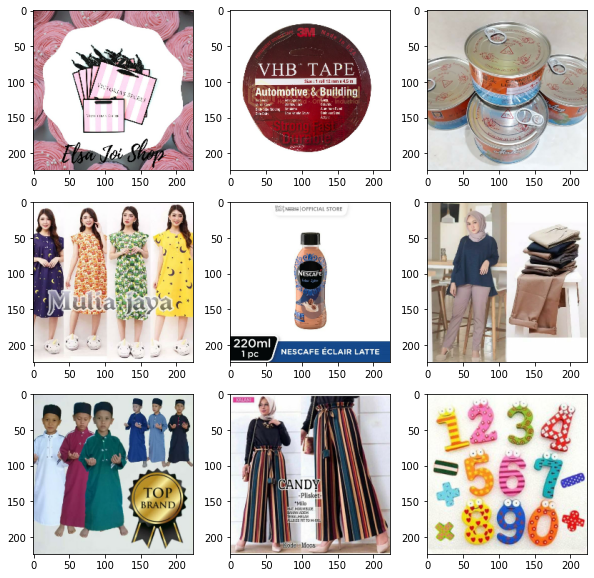

In [8]:
plt.figure(figsize=(10, 10))
for i, image_path, in enumerate(df_train['image_paths'][:9]):
    plt.subplot(3, 3, i + 1)
    image = tf.io.read_file(image_path)
    image = preprocess_image(image) / 255
    plt.imshow(image)
plt.show()

## Train ground truth

In [9]:
tmp = df_train.groupby('label_group').posting_id.agg('unique').to_dict()
df_train['target'] = df_train.label_group.map(tmp)

In [10]:
df_train.head()

,posting_id,image,image_phash,title,label_group,image_paths,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,/Users/ygong/Side_Projects/Kaggle_shopee/data/...,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,/Users/ygong/Side_Projects/Kaggle_shopee/data/...,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,/Users/ygong/Side_Projects/Kaggle_shopee/data/...,"[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,/Users/ygong/Side_Projects/Kaggle_shopee/data/...,"[train_2406599165, train_3342059966]"
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,/Users/ygong/Side_Projects/Kaggle_shopee/data/...,"[train_3369186413, train_921438619]"


# Image embedding

In [11]:
model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=None)

In [12]:
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [13]:
train_embeddings_image = model.predict(train_ds, verbose=1)
df_train['embeddings'] = train_embeddings_image.tolist()

268/268 [==============================] - 711s 3s/step


In [ ]:
test_embeddings_image = model.predict(test_ds)
df_test['embeddings'] = test_embeddings_image.tolist()

# K-Nearest Neighbors

In [14]:
knn = NearestNeighbors(n_neighbors=50)
knn.fit(train_embeddings_image)

NearestNeighbors(n_neighbors=50)

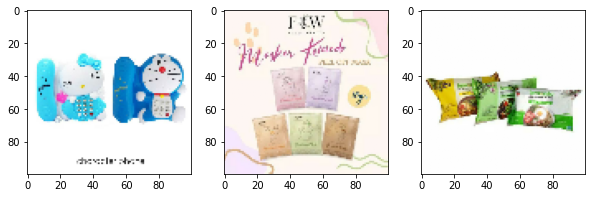

In [96]:
plt.figure(figsize=(10, 4))
for i, image_path, in enumerate(df_test['image_paths'][:3]):
    plt.subplot(1, 3, i + 1)
    image = tf.io.read_file(image_path)
    image = preprocess_image(image)
    plt.imshow(image)
plt.show()

In [15]:
dist, idx = knn.kneighbors(train_embeddings_image)

In [16]:
counts = (dist < 7).sum(axis=1)

In [17]:
for i, row in df_train.iterrows():
    df_train.loc[i, 'matches'] = ' '.join(df_train['posting_id'][idx[i, :counts[i]]].tolist())

In [20]:
def row_wise_f1_score(y_true, y_pred):

    y_true = y_true.apply(lambda x: set(x))
    y_pred = y_pred.apply(lambda x: set(x.split()))

    tp = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    fp = y_pred.apply(lambda x: len(x)).values - tp
    fn = y_true.apply(lambda x: len(x)).values - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * ((precision * recall) / (precision + recall))
    return f1

df_train['f1'] = row_wise_f1_score(df_train['target'], df_train['matches'])
df_train['f1'].mean()

0.6442380523063429

# Submission

In [119]:
df_submit = pd.read_csv('./data/sample_submission.csv')
df_submit

,posting_id,matches
0,test_2255846744,test_2255846744
1,test_3588702337,test_3588702337
2,test_4015706929,test_4015706929


In [138]:
_, idx = knn.kneighbors(test_embeddings_image)

In [143]:
for i, row in df_submit.iterrows():
    df_submit.loc[i, 'matches'] = ' '.join(df_submit['posting_id'][idx[i, :]].tolist())

In [137]:
df_submit.to_csv('submission.csv', index=False)

,posting_id,matches
0,test_2255846744,test_2255846744 test_4015706929 test_3588702337
1,test_3588702337,test_3588702337 test_4015706929 test_2255846744
2,test_4015706929,test_4015706929 test_2255846744 test_3588702337
